In [32]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

# Define custom mean percentage error loss function
def mean_percentage_error(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    
    percentage_error = K.abs((y_true - y_pred) / y_true) * 100
    mean_percentage_error = K.mean(percentage_error, axis=-1)
    
    return mean_percentage_error


pools_daily = pd.read_csv('../data/pools_daily_ILoss.csv', delimiter=';', parse_dates=True)


# Feature Engineering
df_0 = pools_daily[['Date', 'Token0 Price', 'Volume Token 0', 'Token0 Price Change']]
df_1 = pools_daily[['Date', 'Token1 Price', 'Volume Token 1', 'Token1 Price Change']]


df_0['Next Token0 Price'] = df_0['Token0 Price'].shift(-1)
df_1['Next Token1 Price'] = df_1['Token1 Price'].shift(-1)



C:\Users\yinki\AppData\Local\Temp\ipykernel_27456\1934457281.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['Next Token0 Price'] = df_0['Token0 Price'].shift(-1)
C:\Users\yinki\AppData\Local\Temp\ipykernel_27456\1934457281.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Next Token1 Price'] = df_1['Token1 Price'].shift(-1)


            0         1         2
0    0.291946  0.088386  0.409070
1    0.409070  0.118705  0.742325
2    0.742325  0.150100  0.606054
3    0.606054  0.140808  0.872773
4    0.872773  0.119182  0.941715
..        ...       ...       ...
659  0.160918  0.135723  0.157534
660  0.157534  0.072897  0.169582
661  0.169582  0.065409  0.167673
662  0.167673  0.092839  0.159876
663  0.159876  0.088533  0.057655

[664 rows x 3 columns]
            0         1         2
0    0.057655  0.028474  0.175697
1    0.175697  0.123339  0.150526
2    0.150526  0.108861  0.213784
3    0.213784  0.117769  0.238494
4    0.238494  0.077737  0.235199
..        ...       ...       ...
280  0.230151  0.058185  0.223816
281  0.223816  0.009174  0.156680
282  0.156680  0.079304  0.142711
283  0.142711  0.047181  0.275624
284  0.275624  0.052371       NaN

[285 rows x 3 columns]
280 (280,)
(659, 5, 2) (659,) (280, 5, 2) (280,)
Epoch 1/200
21/21 [==============================] - 5s 44ms/step - loss: 0.0662 - val_

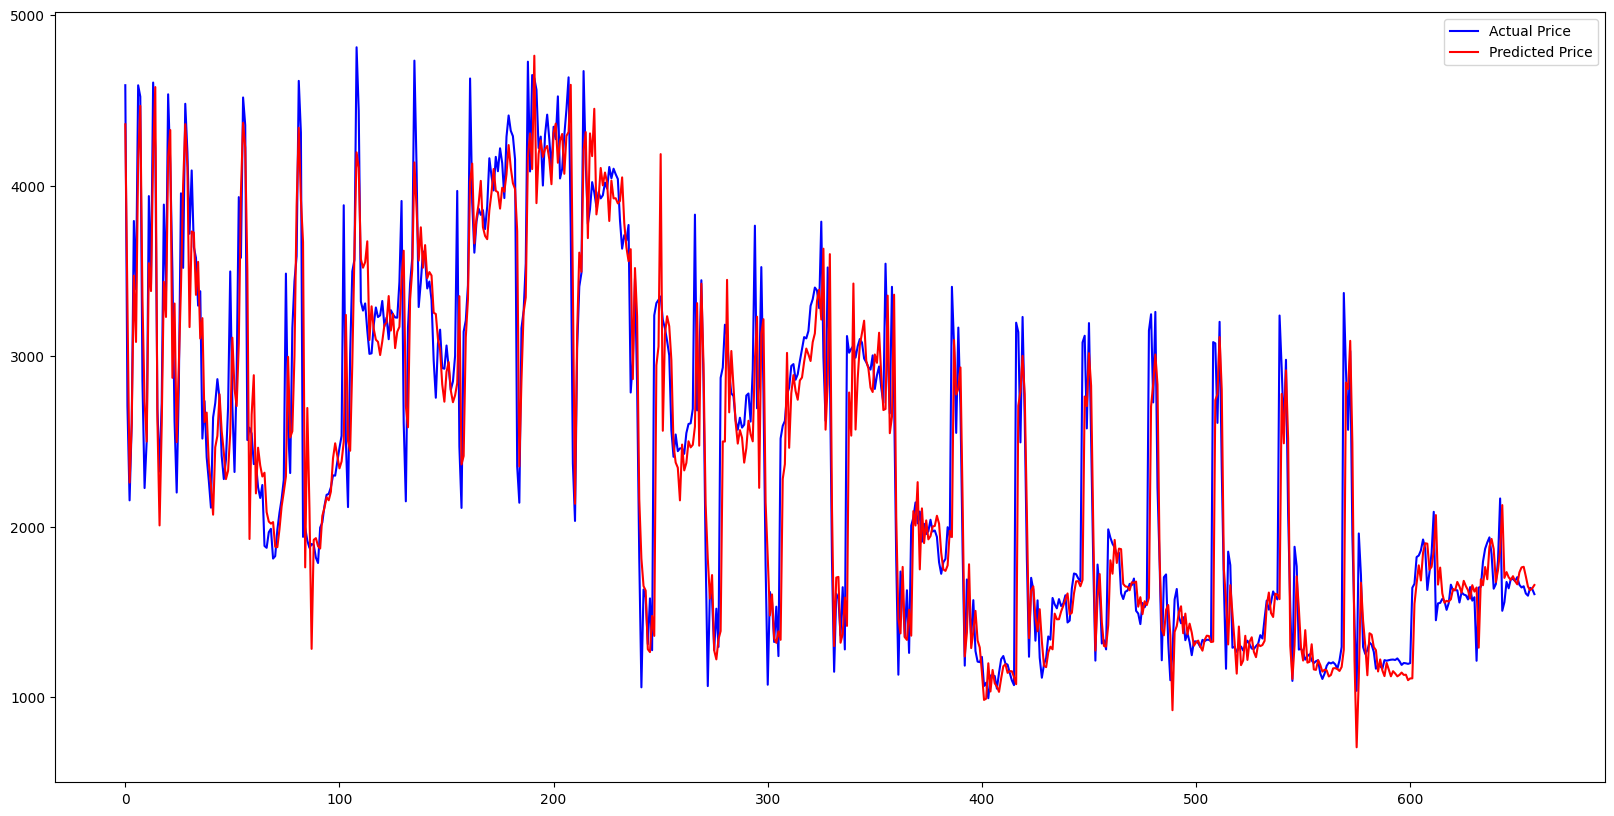

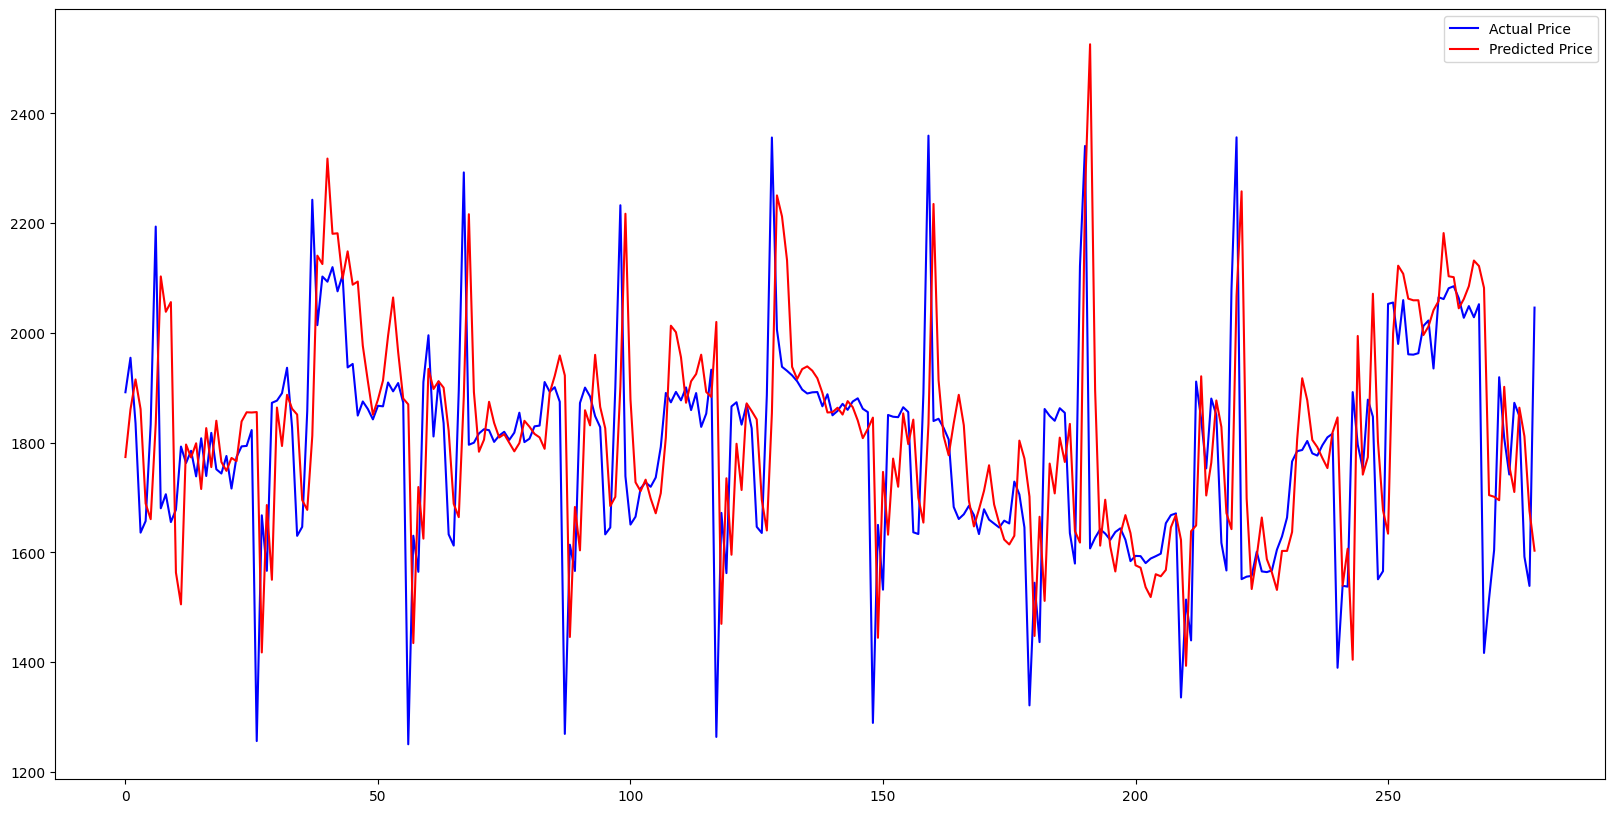

In [33]:
# Building for Token0

# Load your dataset
# Assuming df_0 is your DataFrame with the given columns
# Date, Token0 Price, Volume Token 0, Token0 Price Change
# Make sure Date is in datetime format

# Feature selection
features = df_0[['Token0 Price', 'Volume Token 0', 'Next Token0 Price']]
target = df_0['Next Token0 Price']


# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))


train, test = features_scaled[0:int(
    len(df_0) * 0.7), :], features_scaled[int(len(df_0) * 0.7):, :]


# Define the function to create sequences for LSTM
def create_sequences(data, n, starting_index=0):
    data = pd.DataFrame(data)
    print(data)
    x, y = [], []
    dates = []
    for i in range(len(data) - n):
        x.append(data.iloc[i:(i + n), 0:2])
        # append close price
        y.append(data.iloc[i + n - 1, -1])
        
        dates.append(df_1['Date'].iloc[starting_index + i + n - 1])
    return np.array(x), np.array(y), dates

# Set the sequence length
sequence_length = 5  # You can adjust this based on your preference

# Create sequences
train_x, train_y, train_dates = create_sequences(train, 5, 0)
test_x, test_y, test_dates = create_sequences(test, 5, int(len(df_1) * 0.7))

print(len(test_dates), test_y.shape)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# Identify Nan values

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True,
               input_shape=(5, 2)))
#mode3.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=False))
#mode3.add(Dropout(0.5))
model.add(Dense(30))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train the model
model.fit(train_x, train_y, epochs=200, batch_size=32, validation_data=(test_x, test_y), verbose=1)

# Make predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

# Calculate MAE
train_mae = mean_absolute_error(train_y[0], train_predict[:, 0])
test_mae = mean_absolute_error(test_y[0], test_predict[:, 0])


# Calculate MAPE
train_mape = mean_absolute_percentage_error(train_y[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_y[0], test_predict[:, 0])

print(f'Training MAE: {train_mae}')
print(f'Testing MAE: {test_mae}')
print(f'Training MAPE: {train_mape}')
print(f'Testing MAPE: {test_mape}')


# Plot the Train Results
plt.figure(figsize=(20, 10))
plt.plot(train_y[0], color='blue', label='Actual Price')
plt.plot(train_predict[:, 0], color='red', label='Predicted Price')
plt.legend()
plt.show()

# Plot the Test Results
plt.figure(figsize=(20, 10))
plt.plot(test_y[0], color='blue', label='Actual Price')
plt.plot(test_predict[:, 0], color='red', label='Predicted Price')
plt.legend()


# Make Prediction Dataframe test with dates
token0_price_prediction = pd.DataFrame(test_dates, columns=['Date'])
token0_price_prediction['Token0 Price Prediction'] = test_predict[:, 0]
token0_price_prediction['Token0 Next Price'] = test_y[0]


            0         1         2
0    0.333859  0.064423  0.229892
1    0.229892  0.071484  0.066931
2    0.066931  0.065695  0.118419
3    0.118419  0.069763  0.029243
4    0.029243  0.043394  0.012628
..        ...       ...       ...
659  0.518661  0.130991  0.524967
660  0.524967  0.071802  0.502965
661  0.502965  0.063502  0.506368
662  0.506368  0.088579  0.520592
663  0.520592  0.085310  0.771564

[664 rows x 3 columns]
            0         1         2
0    0.771564  0.036776  0.492261
1    0.492261  0.116917  0.538360
2    0.538360  0.108403  0.431810
3    0.431810  0.102498  0.397526
4    0.397526  0.065029  0.401900
..        ...       ...       ...
280  0.408716  0.048361  0.417469
281  0.417469  0.007769  0.526576
282  0.526576  0.077866  0.553844
283  0.553844  0.047853  0.351954
284  0.351954  0.040039       NaN

[285 rows x 3 columns]
280 (280,)
(659, 5, 2) (659,) (280, 5, 2) (280,)
Epoch 1/200
21/21 [==============================] - 5s 69ms/step - loss: 0.0710 - val_

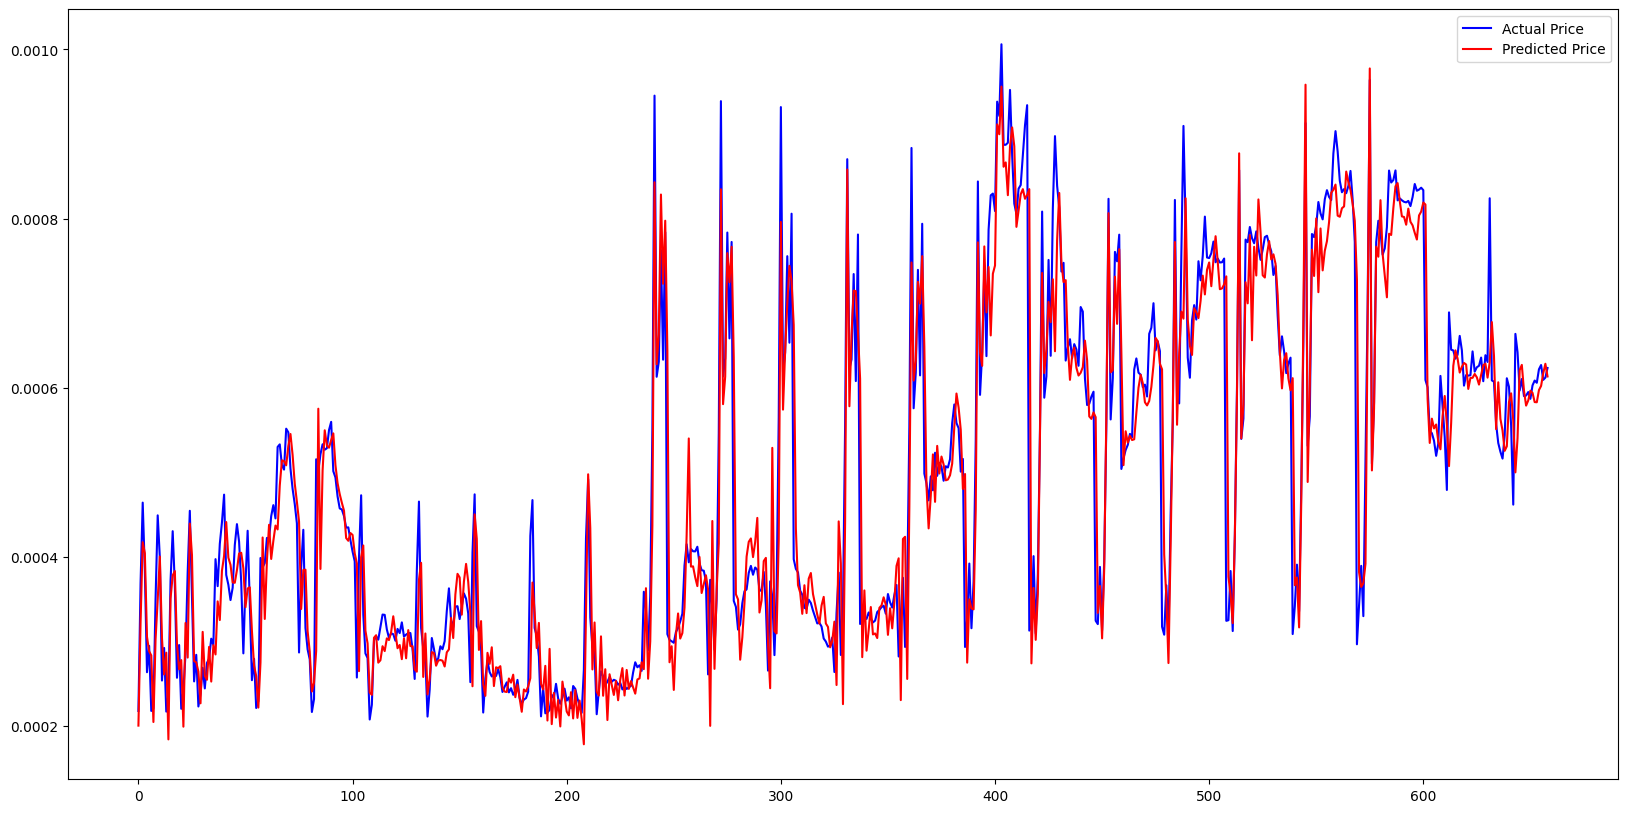

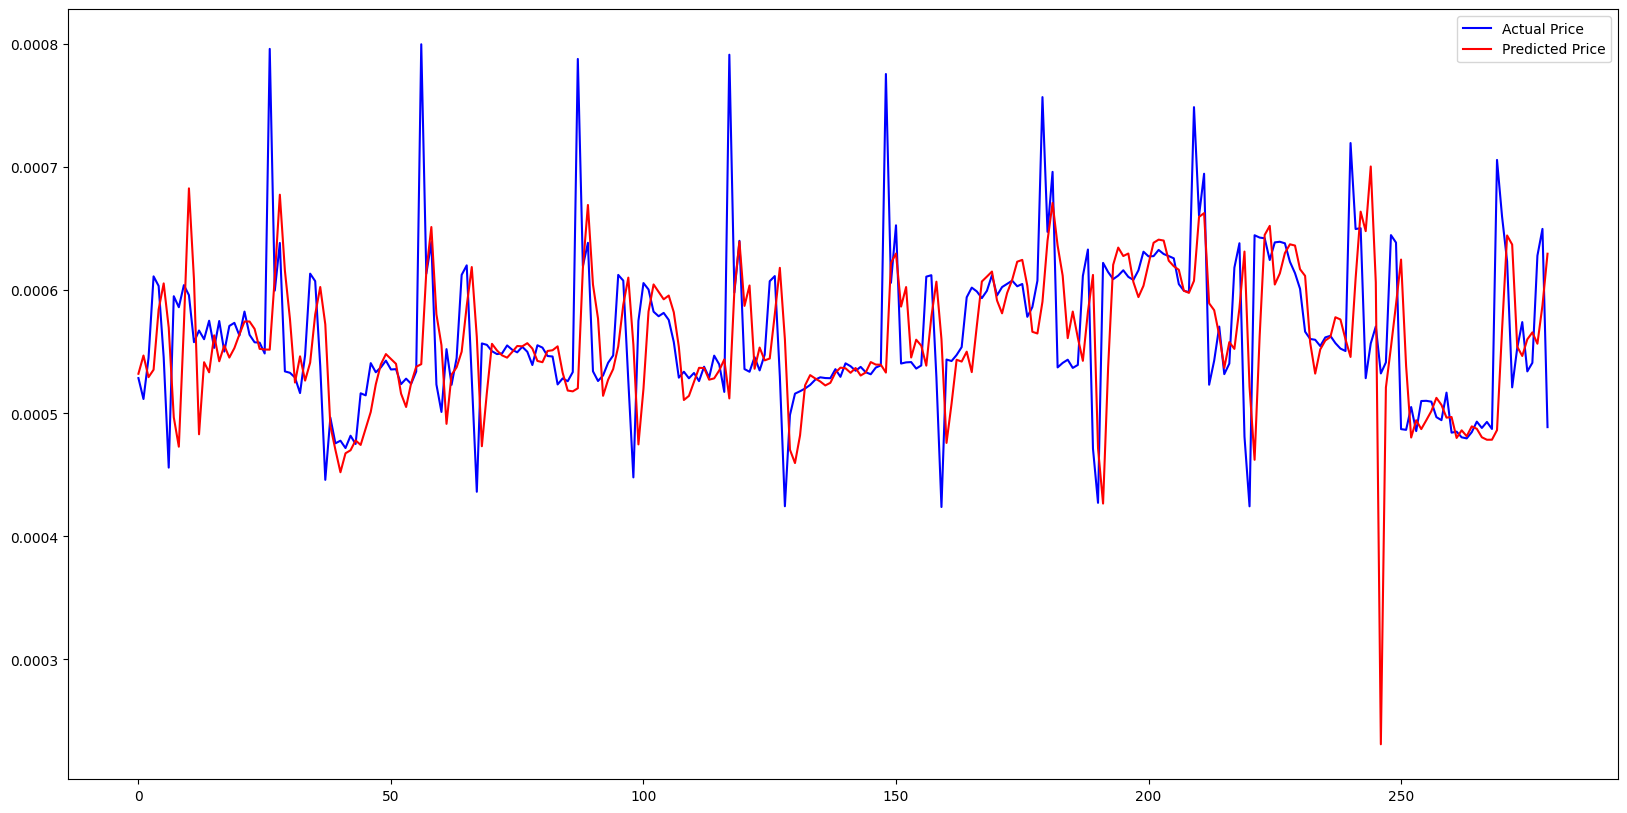

In [34]:
# Repeat for Token1

# Load your dataset
# Assuming df_1 is your DataFrame with the given columns
# Date, Token1 Price, Volume Token 0, Token1 Price Change
# Make sure Date is in datetime format

# Feature selection
features = df_1[['Token1 Price', 'Volume Token 1', 'Next Token1 Price']]
target = df_1['Next Token1 Price']


# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

train, test = features_scaled[0:int(
    len(df_1) * 0.7), :], features_scaled[int(len(df_1) * 0.7):, :]

# Define the function to create sequences for LSTM
def create_sequences(data, n, starting_index):
    data = pd.DataFrame(data)
    print(data)
    x, y = [], []
    dates = []
    for i in range(len(data) - n):
        x.append(data.iloc[i:(i + n), 0:2])
        # append close price
        y.append(data.iloc[i + n - 1, -1])
        
        dates.append(df_1['Date'].iloc[starting_index + i + n - 1])
    return np.array(x), np.array(y), dates

# Set the sequence length
sequence_length = 5  # You can adjust this based on your preference

# Create sequences
train_x, train_y, train_dates = create_sequences(train, 5, 0)
test_x, test_y, test_dates = create_sequences(test, 5, int(len(df_1) * 0.7))

print(len(test_dates), test_y.shape)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True,
               input_shape=(5, 2)))
#mode3.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=False))
#mode3.add(Dropout(0.5))
model.add(Dense(30))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train the model
model.fit(train_x, train_y, epochs=200, batch_size=32, validation_data=(test_x, test_y), verbose=1)

# Make predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

# Calculate MAE
train_mae = mean_absolute_error(train_y[0], train_predict[:, 0])
test_mae = mean_absolute_error(test_y[0], test_predict[:, 0])

print(f'Training MAE: {train_mae}')
print(f'Testing MAE: {test_mae}')

# Calculate MAPE
train_mape = mean_absolute_percentage_error(train_y[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_y[0], test_predict[:, 0])
print(f'Training MAPE: {train_mape}')
print(f'Testing MAPE: {test_mape}')


# Plot the Train Results
plt.figure(figsize=(20, 10))
plt.plot(train_y[0], color='blue', label='Actual Price')
plt.plot(train_predict[:, 0], color='red', label='Predicted Price')
plt.legend()
plt.show()

# Plot the Test Results
plt.figure(figsize=(20, 10))
plt.plot(test_y[0], color='blue', label='Actual Price')
plt.plot(test_predict[:, 0], color='red', label='Predicted Price')
plt.legend()


# Make Prediction Dataframe test with dates
token1_price_prediction = pd.DataFrame(test_dates, columns=['Date'])
token1_price_prediction['Token1 Price Prediction'] = test_predict[:, 0]
token1_price_prediction['Token1 Next Price'] = test_y[0]


In [35]:
print(token0_price_prediction.head(10))

                  Date  Token0 Price Prediction  Token0 Next Price
0  2023-03-05 08:00:00              1773.669434        1891.758467
1  2023-03-06 08:00:00              1860.519165        1954.625283
2  2023-03-07 08:00:00              1915.112915        1835.225788
3  2023-03-08 08:00:00              1861.053223        1635.883277
4  2023-03-09 08:00:00              1688.953369        1656.971360
5  2023-03-10 08:00:00              1660.378662        1833.047083
6  2023-03-11 08:00:00              1834.008667        2193.719245
7  2023-03-12 08:00:00              2102.867920        1680.247237
8  2023-03-13 08:00:00              2038.440186        1705.860426
9  2023-03-14 08:00:00              2056.078125        1655.176966


In [36]:
print(token1_price_prediction.head(10))

                  Date  Token1 Price Prediction  Token1 Next Price
0  2023-03-05 08:00:00                 0.000532           0.000529
1  2023-03-06 08:00:00                 0.000547           0.000512
2  2023-03-07 08:00:00                 0.000529           0.000545
3  2023-03-08 08:00:00                 0.000535           0.000611
4  2023-03-09 08:00:00                 0.000584           0.000604
5  2023-03-10 08:00:00                 0.000606           0.000546
6  2023-03-11 08:00:00                 0.000570           0.000456
7  2023-03-12 08:00:00                 0.000497           0.000595
8  2023-03-13 08:00:00                 0.000473           0.000586
9  2023-03-14 08:00:00                 0.000571           0.000604


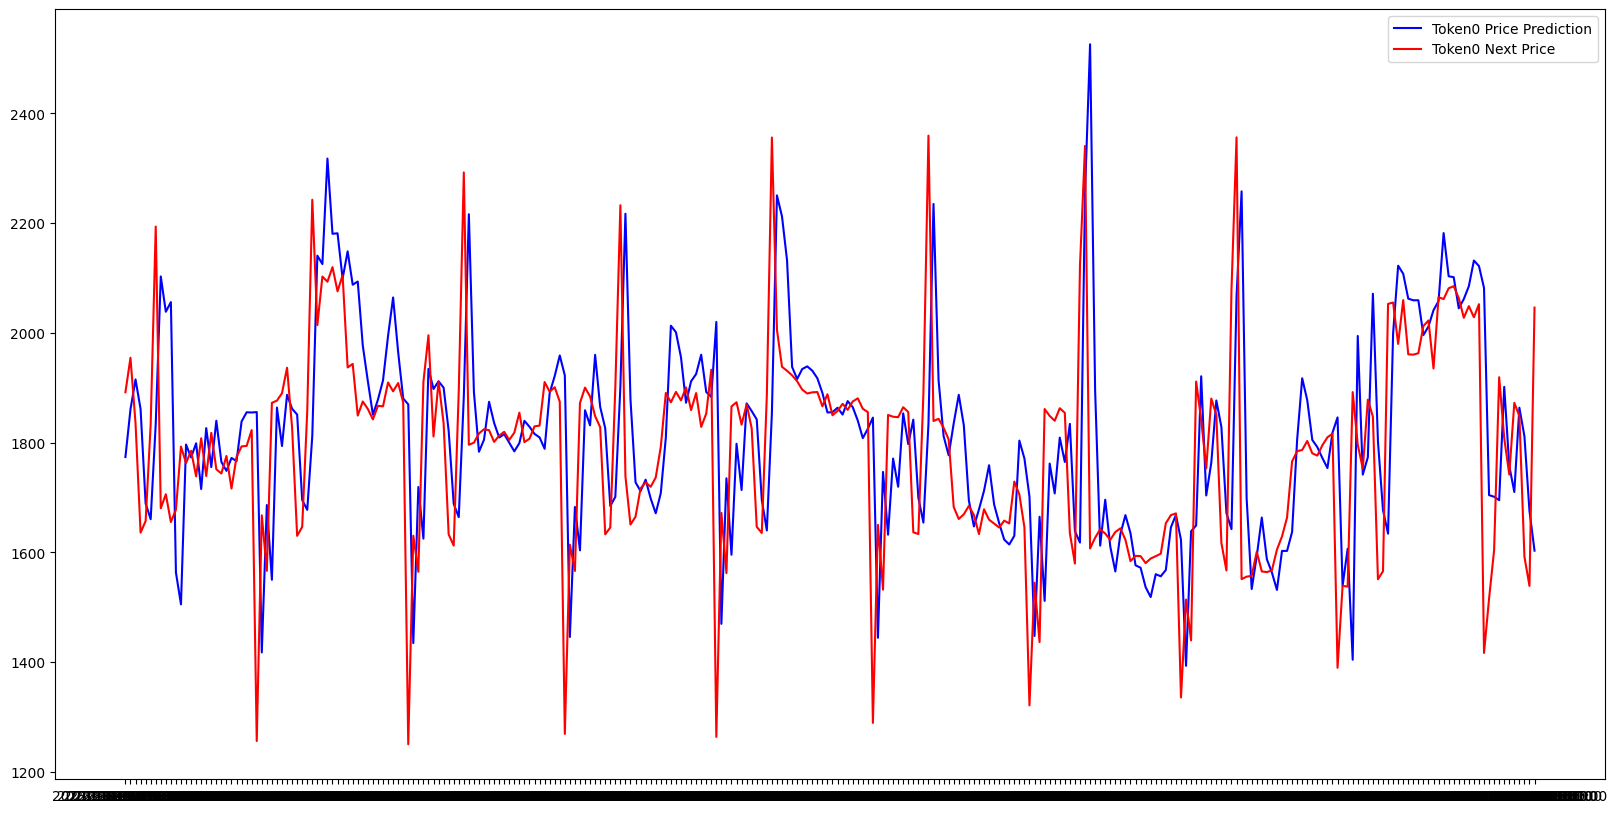

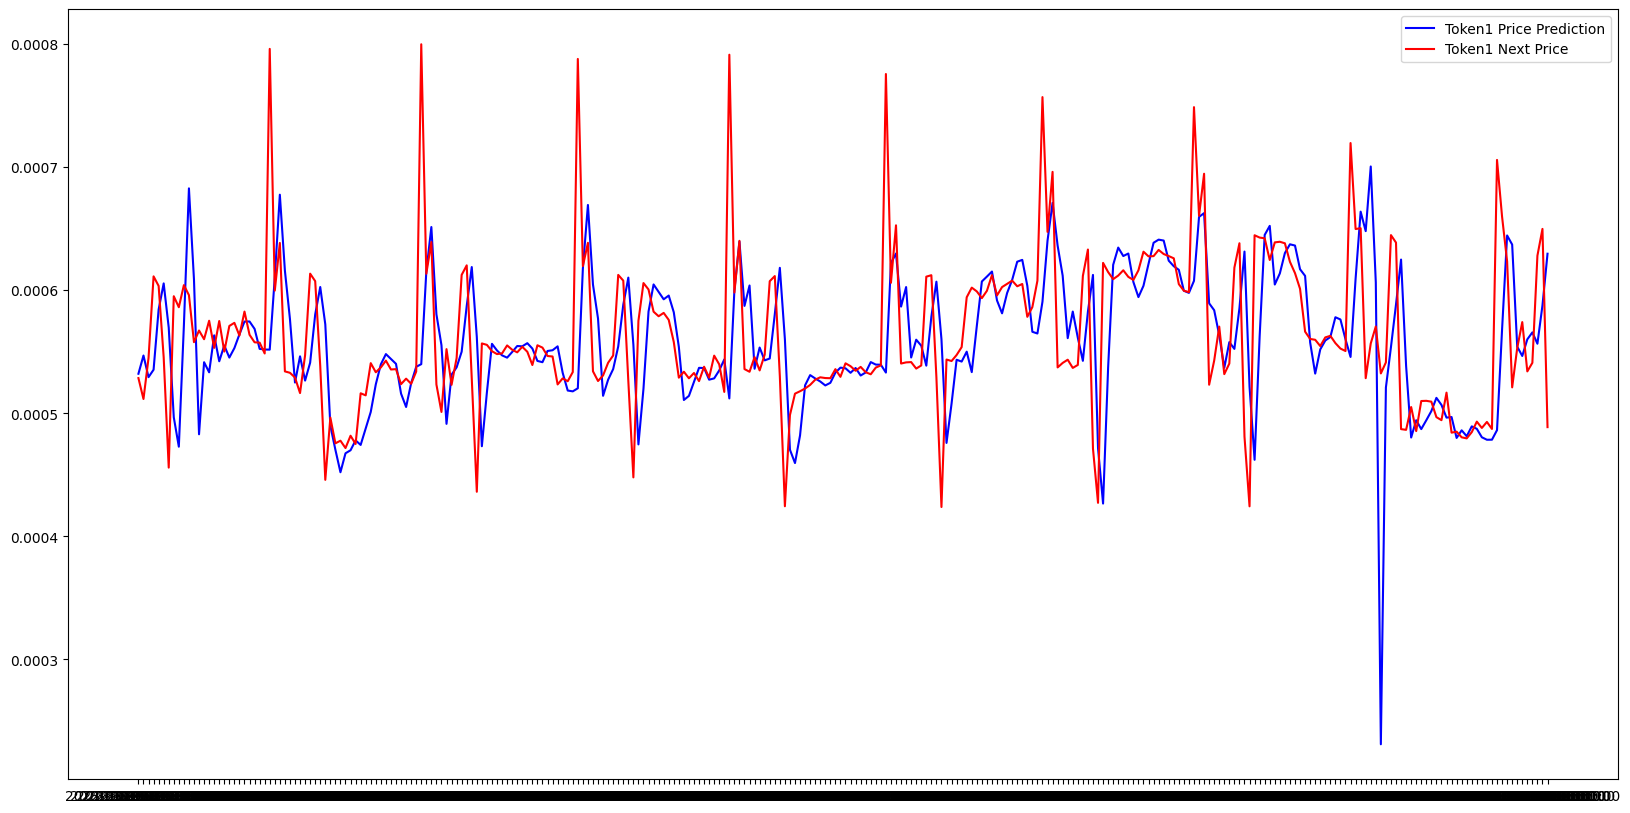

In [37]:
#Plot the results
plt.figure(figsize=(20, 10))
plt.plot(token0_price_prediction['Date'], token0_price_prediction['Token0 Price Prediction'], color='blue', label='Token0 Price Prediction')
plt.plot(token0_price_prediction['Date'], token0_price_prediction['Token0 Next Price'], color='red', label='Token0 Next Price')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(token1_price_prediction['Date'], token1_price_prediction['Token1 Price Prediction'], color='blue', label='Token1 Price Prediction')
plt.plot(token1_price_prediction['Date'], token1_price_prediction['Token1 Next Price'], color='red', label='Token1 Next Price')
plt.legend()
plt.show()


In [38]:
# Append back to original dataframe, based on same date
pools_daily = pools_daily.merge(token0_price_prediction, how='left', on='Date')
pools_daily = pools_daily.merge(token1_price_prediction, how='left', on='Date')
pools_daily

,ID,Date,Date (Unix),Pool,Pool Tokens,Liquidity,Sqrt Price,Token0 Price,Token1 Price,Tick,...,Price Ratio,Impermanent Loss (Stable Coin),Impermanent Loss (Token),Virtual Price,Virtual Price Change,Effective Fee,Token0 Price Prediction,Token0 Next Price,Token1 Price Prediction,Token1 Next Price
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-18809,2021-01-07 08:00:00,1625097600,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,6.572546e+18,"1,725,479,688,395,216,800,000,000,000,000,000",2108.334254,0.000474,"199,783",...,0.641920,0.006110,-0.024070,1.314509e+19,NaN,-1.0,NaN,NaN,NaN,NaN
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-18840,2021-01-08 08:00:00,1627776000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,8.556401e+18,"1,567,310,799,011,734,800,000,000,000,000,000",2555.341308,0.000391,"197,860",...,1.468990,-0.004604,0.018207,1.711280e+19,1.301840,-1.0,NaN,NaN,NaN,NaN
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-18871,2021-01-09 08:00:00,1630454400,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,2.028041e+18,"1,280,671,527,367,842,600,000,000,000,000,000",3827.222041,0.000261,"193,820",...,2.243208,-0.020056,0.076387,4.056082e+18,0.237020,-1.0,NaN,NaN,NaN,NaN
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-18901,2021-01-10 08:00:00,1633046400,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,7.886868e+18,"1,377,695,801,826,872,000,000,000,000,000,000",3307.139370,0.000302,"195,281",...,0.746685,0.002661,-0.010572,1.577374e+19,3.888909,-1.0,NaN,NaN,NaN,NaN
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-18932,2021-01-11 08:00:00,1635724800,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,1.552800e+19,"1,204,709,674,553,587,300,000,000,000,000,000",4325.082256,0.000231,"192,597",...,1.710345,-0.008934,0.034956,3.105601e+19,1.968843,-1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19550,2023-12-07 08:00:00,1689120000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,2.996021e+19,"1,830,921,455,145,474,000,000,000,000,000,000",1872.491003,0.000534,"200,970",...,1.155645,-0.000654,0.002610,5.992042e+19,0.273678,-1.0,1863.629028,1848.316025,0.000566,0.000541
945,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19581,2023-12-08 08:00:00,1691798400,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,5.632675e+19,"1,842,856,289,879,040,800,000,000,000,000,000",1848.316025,0.000541,"201,099",...,0.974345,0.000021,-0.000084,1.126535e+20,1.880052,-1.0,1811.542114,1592.087811,0.000557,0.000628
946,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19612,2023-12-09 08:00:00,1694476800,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,2.513272e+19,"1,985,619,709,190,068,200,000,000,000,000,000",1592.087811,0.000628,"202,592",...,0.741962,0.002777,-0.011032,5.026543e+19,0.446195,-1.0,1675.581543,1538.774881,0.000588,0.000650
947,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19642,2023-12-10 08:00:00,1697068800,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC / WETH,2.726893e+19,"2,019,724,062,301,352,000,000,000,000,000,000",1538.774881,0.000650,"202,932",...,0.934149,0.000145,-0.000580,5.453787e+19,1.084997,-1.0,1603.010376,2046.039941,0.000630,0.000489


In [39]:
# Save to csv 
pools_daily.to_csv('../data/pools_daily_ILoss_Prediction_LSTM.csv', index=False)